# Fluorescence decay curves

Time-resolved fluorescence experiments measure the fluorescence intensity of a sample relative to an excitation pulse. Most time-resolved fluorescence experiments use time-correlated single photon counting (TCSPC) to register the photons emitted by the sample. In TCSPC fluorescence decays are counting histograms that are handled in  `IMP.bff` by the class `IMP.bff.DecayCurve`. Fluorescence decays are usually read from files. Uncertainties of fluorescence decays must be handled and often, in experiments, intensities need to be shifted relative to the laser pulse (e.g., for computing model functions). Fluorescence decays must be able to be combined, e.g., for integrating multiple experiments or for computing the fluorescence anisotropy. Here, the most common tasks needed to process fluorescence decays using `IMP.bff.DecayCurve` objects are illustrated:

 1. Reading files
 2. Accessing and modifying fluorescence decay attributes
 3. Operations on fluorescence decays (addition, subtraction, multiplication, division, shifting)
 
Moreover, it is illustrated how to use these operations to 
 
 1. Integrating measurements
 2. Visualizing FRET using the FRET induced donor decay
 3. Computing time-resolved anisotropy curves

The data processing is illustrated using experiments on the human guanylate binding protein 1 (hGBP1) <cite data-cite="voepel2014triphosphate">Vöpel et al. (2014)</cite>.

First, all necessary libraries are imported. We use [pathlib](https://docs.python.org/3/library/pathlib.html) to operate on file paths, independent of the used operating system, [matplotlib](https://matplotlib.org/) to generate plots, [numpy](https://numpy.org/) to work with arrays, and [pandas](https://pandas.pydata.org/) to load data. Additionally, we use the integrative modeling platform [IMP](https://integrativemodeling.org/) and the Bayesian Fluorescence Framework [IMP.bff](https://docs.peulen.xyz/bff/).

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import IMP
import IMP.bff

## Fluorescence decay curve reading
We read comma-separated value (CSV) files containing the decays using pandas and initialize the `DecayCurve` objects. In the example, the time axis of fluorescence decays is in units of channel numbers. To obtain a time-axis, the channels numbers are multiplied by the channel time width.

To accurately process fluorescence decays, the instrument response function (`irf`) and additional data to correct for differential non linearities (DNL) may be required (`lintable`). Moreover, to interpret time-resolved fluorescence experiments of a fluorophore in the presence of Förster Resonance Energy Transfer (FRET) a reference measurement of the fluorophore in the absence of FRET is required.

In [2]:
dc = IMP.bff.DecayCurve([], [], [], 1, 1, 0)
dc.get_json()

'{"acquisition_time":1.0,"current_shift":0.0,"ey":[],"noise_model":1,"x":[],"y":[]}'

In [3]:
dt = 0.0141 # time resolution (bin width of decay histogram)

fns = {
    "lintable": IMP.bff.get_example_path("spectroscopy/hgbp1_titration/whitelight.txt"),
    "irf": IMP.bff.get_example_path("spectroscopy/hgbp1_titration/Prompt.txt"),
    "donor": IMP.bff.get_example_path("spectroscopy/hgbp1_titration/c00.txt")
}

data_references = dict()
for key in fns:
    df = pd.read_csv(fns[key], skiprows=6, sep='\t')
    data_references[key] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])

In the experimental series the acceptor concentration was varied. Here, we read all files in the `hgbp1_titration` folder and populate a dictionary with `IMP.bff.DecayCurve` objects.

In [4]:
# Read the FRET data
data_fret = dict()
path = IMP.bff.get_example_path("spectroscopy/hgbp1_titration/")
for fn in sorted(pathlib.Path(path).glob("c*.txt")):
    df = pd.read_csv(fn, skiprows=6, sep='\t')
    data_fret[fn.stem] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])

In [5]:
print(data_references.keys())
print(data_fret.keys())

dict_keys(['lintable', 'irf', 'donor'])
dict_keys(['c00', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14'])


Here, larger numbers in the file names correspond to larger acceptor concentrations.

## Fluorescence decay curve attributes
`IMP.bff.DecayCurve` objects contain the most relevant information on the fluorescence decay. The most relevant information is either directly accessed using getter/setter methods or as attributes. The attributes of `IMP.bff.DecayCurve` are illustrated for the `donor` reference curve of the experiment.

In [6]:
c = data_references["donor"]

### Time-axis and counts
The most important attributes of a fluorescence decay are the time-axis and the number of photons (counts) detected at a certain time relative to a laser pulse.

In [7]:
c.x  # Time-axis
c.y  # Counts

array([1., 1., 1., ..., 1., 1., 1.])

Experimental fluorescence decays are typically plotted in a semi logarithmic plot together with the instrument response function (IRF).

Text(0.5, 0, 'Time [ns]')

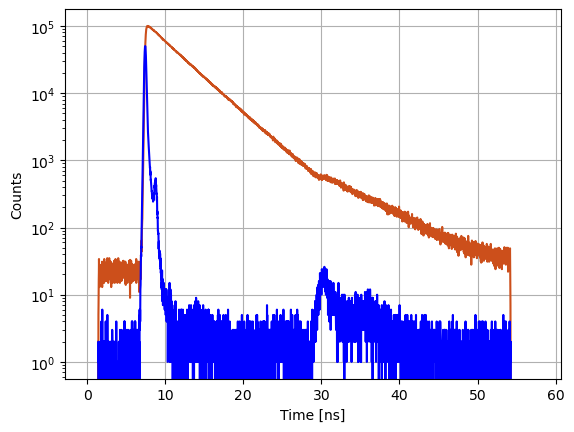

In [8]:
fig = plt.figure()
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs.grid(True)
axs.semilogy(c.x, c.y, '-', color='#CC4F1B')
axs.semilogy(data_references['irf'].x, data_references['irf'].y, '-', color='blue')
axs.set_ylabel('Counts')
axs.set_xlabel('Time [ns]')

In addition to the experimental data, `IMP.bff.DecayCurve` objects keep track of the uncertainties. When a new object is initialized, the uncertainty is computed assuming Poisson counting noise. In case different decays are combined (see below) the uncertainty is propagated by Gaussian error propagation. Note, this is an approximation particularly for low count data.

In [9]:
# Uncertainties are accessed using the ey attribute
c.ey

array([1., 1., 1., ..., 1., 1., 1.])

Text(0.5, 0, 'Time [ns]')

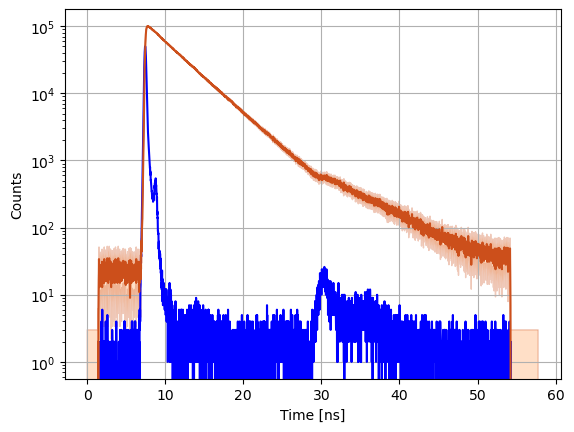

In [11]:
a = 3.0 # 3 sigma factor to make error bands better visible

fig = plt.figure()
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs.grid(True)
axs.semilogy(data_references['irf'].x, data_references['irf'].y, '-', color='blue')
axs.semilogy(c.x, c.y, '-', color='#CC4F1B')
axs.fill_between(c.x, c.y-a*c.ey, c.y+a*c.ey, alpha=0.3, edgecolor='#CC4F1B', facecolor='#FF9848')
axs.set_ylabel('Counts')
axs.set_xlabel('Time [ns]')

### Additional attributes
Fluorescence decay `IMP.bff.DecayCurve` objects have a set of additional attributes that can be used by other routines. For instance, the `IMP.bff.DecayCurve` acquisition time attribute together with the fluorescence decay informs on the average count rate used to estimate and correct for [pile-up](pile-up.ipynb) effects. The most relevant additional attributes are:

1. Acquisition time
2. Shift of the fluorescence decay curve (in channel numbers)
3. Noise model used to compute the uncertainty

Below it is illustrated how to access these attributes.

### Acquisition time
The additional attributes are accessed using getter and setter methods. For instance, the acquisition time is accessed as follows.

In [12]:
c.get_acquisition_time()
c.set_acquisition_time(1800.0)

Alternatively additional attributes are accessed and modified in a more Pythonic way directly. 

In [13]:
c.acquisition_time
c.acquisition_time = 10.0
print(c.acquisition_time)

10.0


### Time shift
Often, fluorescence decays need to be shifted relative to the laser pulse. The fluorescence decay time-axis is discrete. If a decay needs to be shifted only by a fraction of a channel `IMP.bff.DecayCurve` objects apply a linear interpolation. 

In [14]:
c.set_shift(1.0)
c.get_shift()

1.0

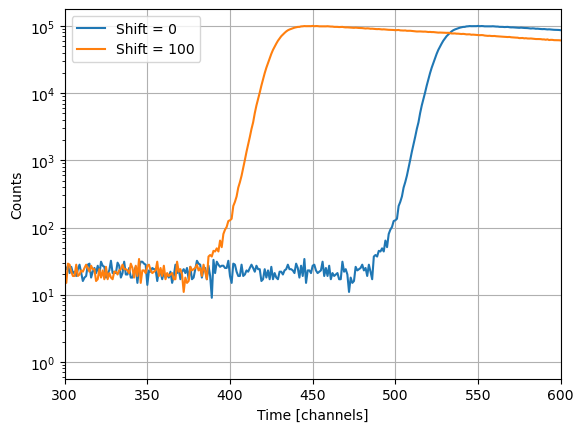

In [34]:
d = data_references["donor"]
fig = plt.figure()
gs = fig.add_gridspec()
ax = gs.subplots()
ax.grid(True)
d.set_shift(0)
ax.semilogy(d.y, label="Shift = 0")

d.set_shift(100)
ax.semilogy(d.y, label="Shift = 100")

ax.set_xlabel('Time [channels]')
ax.set_ylabel('Counts')
ax.set_xlim(300, 600)
ax.legend()

But no worries, when a decay is shifted, the original data is unmodified. Decay curves store the original (initial) data that was used to create a `IMP.bff.DecayCurve` object as private attribute to preserve the original data.

### JSON export
All attributes can be accessed as a JSON string that can be processed in Python.

In [14]:
import json
json_string = data_fret["c0"].get_json()

d = json.loads(json_string)
print(d.keys())

dict_keys(['acquisition_time', 'current_shift', 'ey', 'noise_model', 'x', 'y'])


Note, exporting and importing the attributes as string is slow and can add an overhead to your code.

## Operations on fluorescence decays
`IMP.bff.DecayCurve` objects implement the following operations.

```
    DecayCurve& operator+(double v) const;
    DecayCurve& operator-(double v) const;
    DecayCurve& operator*(double v) const;
    DecayCurve& operator/(double v) const;

    DecayCurve& operator+=(double v);
    DecayCurve& operator-=(double v);
    DecayCurve& operator*=(double v);
    DecayCurve& operator/=(double v);

    DecayCurve& operator+(const DecayCurve& other) const;
    DecayCurve& operator-(const DecayCurve& other) const;
    DecayCurve& operator*(const DecayCurve& other) const;
    DecayCurve& operator/(const DecayCurve& other) const;

    DecayCurve& operator=(const DecayCurve& other);
    
    /// Shift the curve by a float
    DecayCurve& operator<<(double v);

```
Some operations modify `IMP.bff.DecayCurve` objects inplace. Other operations create new `IMP.bff.DecayCurve` objects. Independent of the used operation, the produced object updates the uncertainties by normal (Gaussian) error propagation.

### Addition

In [37]:
c1 = data_fret['c01']
c2 = data_fret['c02']
s12 = c1 + c2

Integrating (adding) fluorescence decays reduces the uncertainty.

/var/folders/cl/txwq_hq52rl_t0f9xjk3g5c00000gn/T/ipykernel_64492/431600868.py:6: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(c1.ey / c1.y * 100.0, label="Measurement 1")
/var/folders/cl/txwq_hq52rl_t0f9xjk3g5c00000gn/T/ipykernel_64492/431600868.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(c2.ey / c2.y * 100.0, label="Measurement 2")
/var/folders/cl/txwq_hq52rl_t0f9xjk3g5c00000gn/T/ipykernel_64492/431600868.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(s12.ey / s12.y * 100.0, label="Measurement 1 & 2")


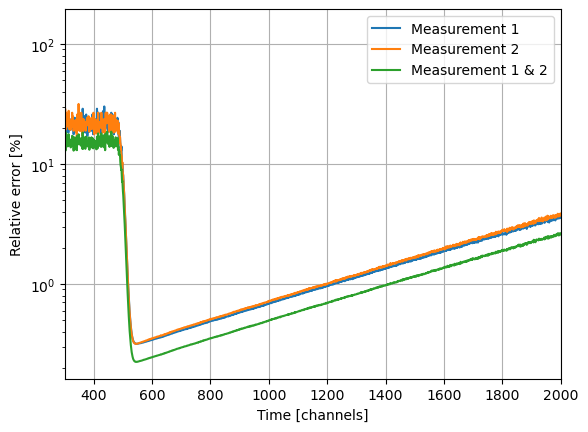

In [42]:
fig = plt.figure()
gs = fig.add_gridspec()
ax = gs.subplots()
ax.grid(True)

ax.semilogy(c1.ey / c1.y * 100.0, label="Measurement 1")
ax.semilogy(c2.ey / c2.y * 100.0, label="Measurement 2")
ax.semilogy(s12.ey / s12.y * 100.0, label="Measurement 1 & 2")

ax.set_xlabel('Time [channels]')
ax.set_ylabel('Relative error [%]')
ax.set_xlim(300, 2000)
ax.legend()

plt.legend()
plt.show()

Note, a constant offset changes the data but not the associated uncertainty.

In [47]:
s12_o = s12 + 1000000

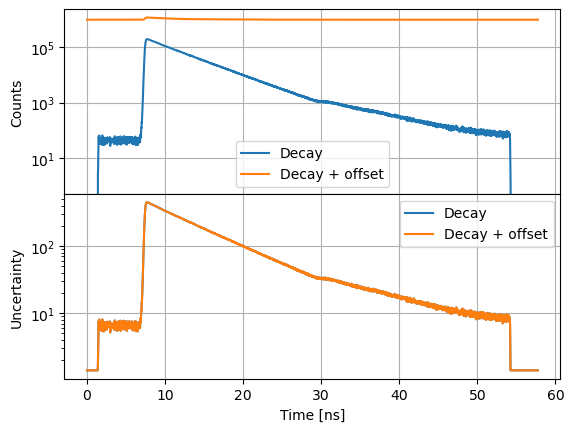

In [49]:
fig = plt.figure()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].semilogy(s12.x, s12.y, label="Decay")
axs[0].semilogy(s12_o.x, s12_o.y, label="Decay + offset")
axs[0].set_ylabel('Counts')
axs[0].grid(True)
axs[0].legend()

axs[1].semilogy(s12.x, s12.ey, label="Decay")
axs[1].semilogy(s12_o.x, s12_o.ey, label="Decay + offset")
axs[1].set_xlabel('Time [ns]')
axs[1].set_ylabel('Uncertainty')
axs[1].grid(True)
axs[1].legend()


### Subtraction


In [50]:
c1 = data_fret['c01']
c2 = data_fret['c02']
d12 = c1 - c2

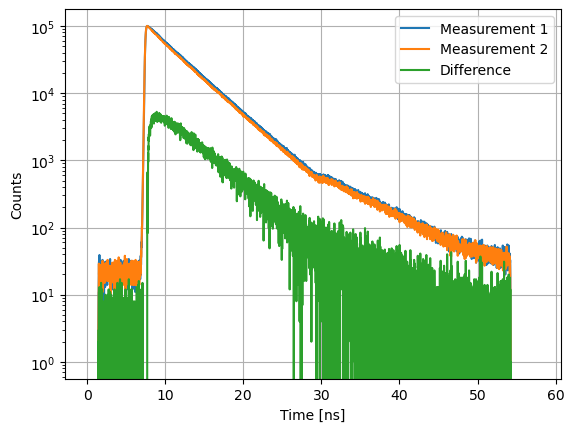

In [55]:
fig = plt.figure()
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs.semilogy(c1.x, c1.y, label="Measurement 1")
axs.semilogy(c1.x, c2.y, label="Measurement 2")
axs.semilogy(c1.x, d12.y, label="Difference")
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Counts')
axs.legend()
axs.grid(True)

Constants subtracted from curves, e.g. to correct for constant backgrounds.

In [61]:
bg = 400.0
d12_bg = d12 - bg

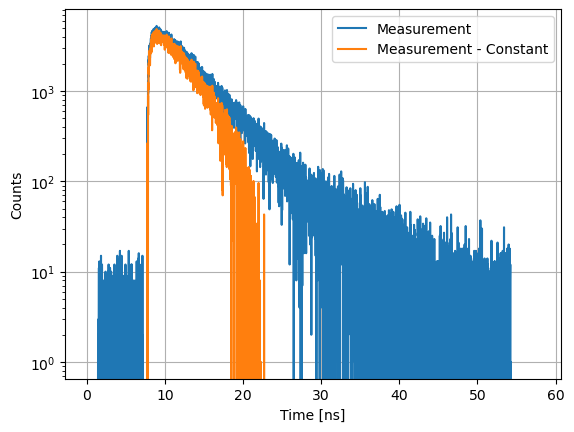

In [62]:
fig = plt.figure()
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs.semilogy(d12.x, d12.y, label="Measurement")
axs.semilogy(d12_bg.x, d12_bg.y, label="Measurement - Constant")
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Counts')
axs.legend()
axs.grid(True)

### Multiplication



In [65]:
c1 = data_fret['c01']
c2 = data_fret['c02']
m12 = c1 * c2

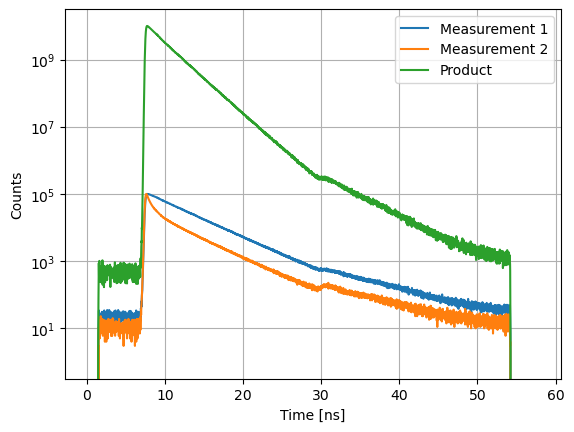

In [69]:
fig = plt.figure()
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs.semilogy(c1.x, c1.y, label="Measurement 1")
axs.semilogy(c2.x, c2.y, label="Measurement 2")
axs.semilogy(m12.x, m12.y, label="Product")

axs.set_xlabel('Time [ns]')
axs.set_ylabel('Counts')
axs.legend()
axs.grid(True)


Curves can be multiplied with constants, e.g., to correct for detection sensitivities in anisotropy and FRET experiments.

### Division
Curves can be divided, e.g., to compute time-resolved anisotropy or FRET induced donor decay curves. Divisions are performed per channel. 

In [70]:
c1 = data_fret['c00']
c2 = data_fret['c14']
d12 = c2 / c1

/var/folders/cl/txwq_hq52rl_t0f9xjk3g5c00000gn/T/ipykernel_64492/680836958.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


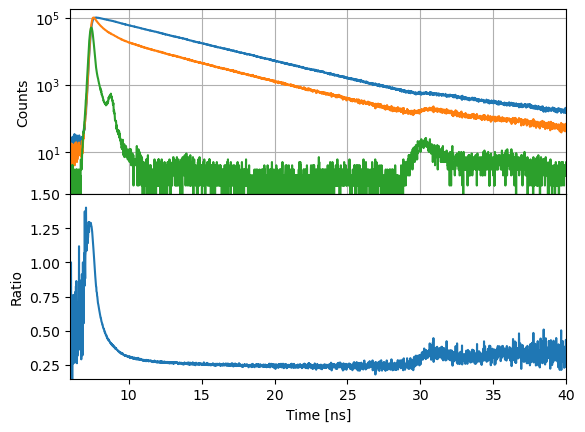

In [71]:
fig = plt.figure()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].semilogy(c1.x, c1.y, c2.x, c2.y)
axs[0].semilogy(
    data_references['irf'].x, 
    data_references['irf'].y
)

axs[0].set_ylabel('Counts')
axs[0].grid(True)

axs[1].plot(d12.x, d12.y)
axs[1].set_ylim(0.15, 1.5)
axs[1].set_xlim(6, 40)
axs[1].set_xlabel('Time [ns]')
axs[1].set_ylabel('Ratio')
fig.show()

### Shifting

`IMP.bff.DecayCurve` objects can be shifted using the shift operator `<<`. The return of a shifting operator is 

In [73]:
c << 22.0

<IMP.bff.DecayCurve; proxy of <Swig Object of type 'IMP::bff::DecayCurve *' at 0x15c5e0300> >

<div class="alert alert-info">
Note, `<<` is a inplace operator. 
</div>

## Integrating data

TCSPC experiments can be recorded piece wise and combined later in a fluorescence decay histogram.

In [74]:
s = IMP.bff.DecayCurve() # Used to integrate experiments
s.x = data_references['donor'].x
for k in data_fret:
    s = s + data_fret[k]

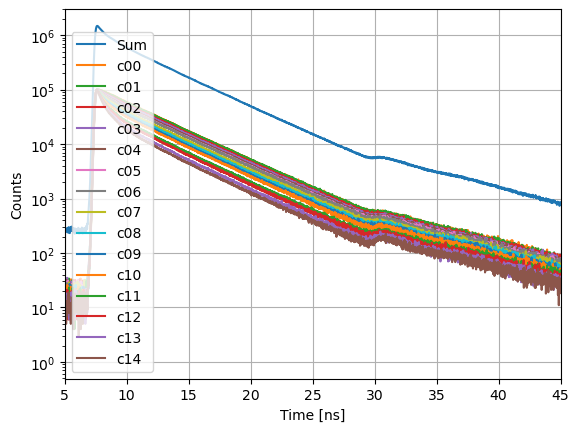

In [77]:
fig = plt.figure()

gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs.semilogy(s.x,s.y, label="Sum")
for k in data_fret:
    d = data_fret[k]
    axs.semilogy(d.x, d.y, label=k)

axs.set_xlim(5, 45)
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Counts')
axs.grid(True)
plt.legend()

## FRET induced donor decay
The fluorescence decay of the donor in the presence of FRET, $f_{D|D}^{(DA)}(t)$, can be related to the fluorescence decay of the donor in the absence of FRET $f_{D|D}^{(D0)}(t)$.

\begin{equation}
f_{D|D}^{(DA)}(t)=\epsilon_{D}(t)f_{D|D}^{(D0)}(t)
\end{equation}

Here, $\epsilon_{D}(t)$ is the FRET induced donor decay <cite data-cite="peulen2017">Peulen et al. (2017)</cite>. In case of a homogeneous quenched dye, the FRET induced donor decay directly relates to FRET rate constants. Like, $r(t)$, the time-resolved anisotropy, that helps visualizing the depolarization, e.g. due to rotation, the FRET induced donor decay can be used to visualize FRET. Here, we visualize $\epsilon_{D}(t)$ for a sample where the acceptor concentration was varied, to identify dependencies of FRET.

The curve $\epsilon_{D}(t)$ is computed for a decay $f_{D|D}^{(DA)}(t)$ and a reference curve $f_{D|D}^{(D0)}(t)$. We first define a reference donor curve.

In [78]:
donor = data_references["donor"]

We are dividing the experimental $f_{D|D}^{(DA)}(t)$ by the reference. Here, the reference is a noisy experiment. Division by a noisy reference increases the total noise. Thus, for visualization, it can make sense to apply a filter to reduce the noise.

In [79]:
# smooth donor -> first make a copy
donor_smooth = IMP.bff.DecayCurve(donor.x, donor.y)
# Simple moving average
sma_kw = {
    "start": 0,
    "stop": 4096,
    "n_window": 2,
    "normalize": False
}
donor_smooth.apply_simple_moving_average(**sma_kw)

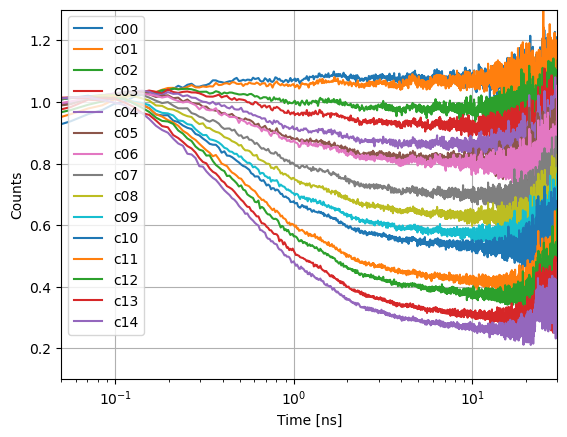

In [84]:
fig = plt.figure()

gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)


ets = dict()
for k in data_fret:
    fret = data_fret[k]
    et = fret / donor_smooth
    # Shift decays (irf) to approx t=0
    et = et << 535.0
    ets[k] = et
    axs.semilogx(et.x, et.y, label=k)

axs.set_ylim((0.1, 1.3))
axs.set_xlim((0.05, 30.0))
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Counts')
axs.grid(True)
axs.legend()


In the FRET induced donor decay, $\epsilon_D(t)$, FRET inactive species correspond to a constant offset, $x_{DO}$. In the experiments, the constant offset changes. An indication for a change of the fraction of FRET inactive species. The fraction of FRET inactive species can be estimated by the offset.

In a $\epsilon_D$ plot the characteristic time of the FRET process can be best visualized in a semi logarithmic plot.

Text(0, 0.5, '$\\epsilon_D$')

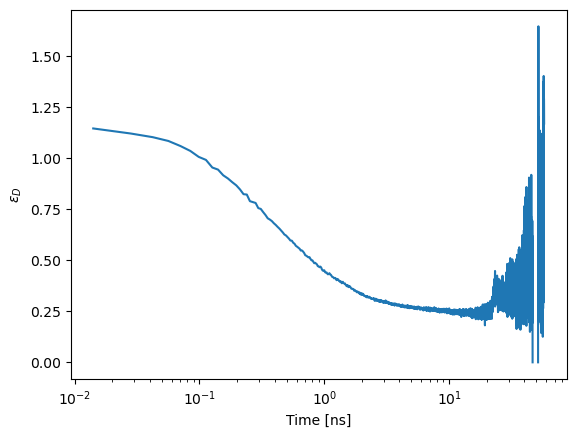

In [88]:
d12 << 535
fig, ax = plt.subplots()
ax.semilogx(d12.x, d12.y)
ax.set_xlabel('Time [ns]')
ax.set_ylabel('$\epsilon_D$')

For a single exponential FRET induced donor decay $\epsilon_D(t)=exp(-k_{FRET}\cdot t)$. The curve $\epsilon_D(t) \cdot t =exp(-k_{FRET}\cdot t) \cdot t$ has its maximum at the time $1/k_{FRET}$. Hence, for a single exponential decay, the corresponding FRET distance is identified by the maximum in the following plot. 

In [89]:
donor_only = 0.25 # The donor only can be estimated from the offset
d12_xdo = d12 - donor_only

/var/folders/cl/txwq_hq52rl_t0f9xjk3g5c00000gn/T/ipykernel_64492/4206751574.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 20)


(0.009302530770948904, 20)

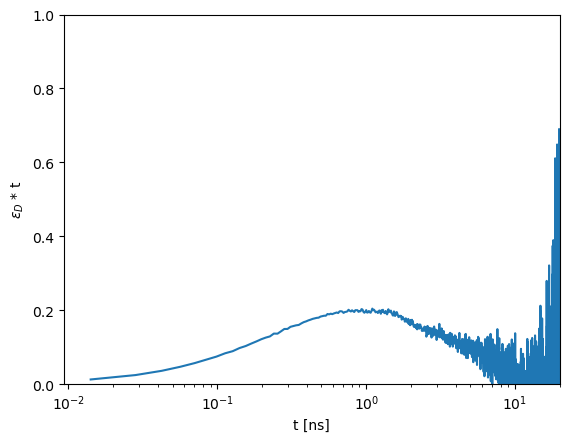

In [90]:
fig, ax = plt.subplots()
ax.semilogx(d12_xdo.x, d12_xdo.y * d12_xdo.x)
ax.set_xlabel('t [ns]')
ax.set_ylabel('$\epsilon_D$ * t')
ax.set_ylim(0, 1)
ax.set_xlim(0, 20)

The characteristic time can be visually identified by the maximum. The Förster equation $k_{FRET}=1/\tau_0 (R_0/R_{DA})^{6}$ relates the time of the FRET process to a distance via the Förster radius $R_0$ and the corresponding fluorescence lifetime of the donor in the absence of FRET $\tau_0$.

In [91]:
foerster_radius = 52.0
tau0 = 4.1
rdac = foerster_radius * (1./tau0 * d12.x)**(1./6.)

(15.0, 70.0)

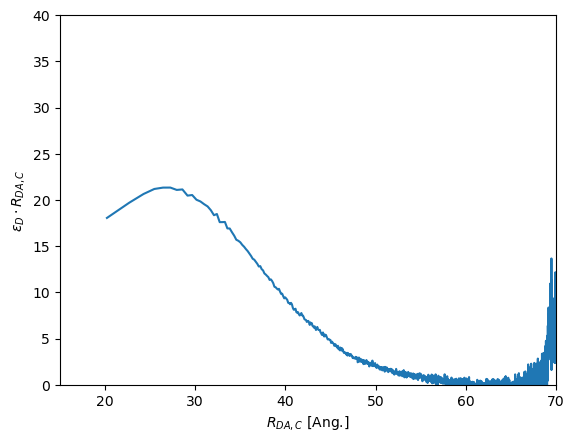

In [92]:
c = (d12 - donor_only)
fig, ax = plt.subplots()
ax.plot(rdac, c.y  * rdac)
ax.set_xlabel('$R_{DA,C}$ [Ang.]')
ax.set_ylabel('$\epsilon_D \cdot R_{DA,C}$')
ax.set_ylim(0, 40)
ax.set_xlim(15, 70)

The position of $\epsilon_D \cdot R_{DA,C}$ corresponds to a distance. Using such a transformation and non-FRET active species correction measurements at different acceptor concentrations can be compared to identify potential changes in FRET that could be related to oligomerization.

/var/folders/cl/txwq_hq52rl_t0f9xjk3g5c00000gn/T/ipykernel_64492/198105477.py:8: RuntimeWarning: invalid value encountered in divide
  y /= max(y[0:800])


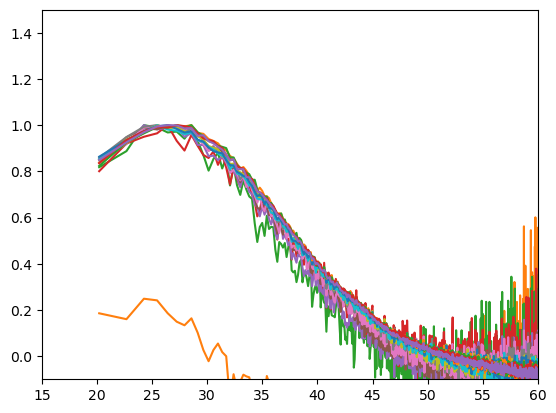

In [94]:
for k in data_fret:
    fret = data_fret[k]
    et = fret / data_fret['c00']
    do = np.mean(et.y[900:2900]) 
    # Shift decays (irf) to approx t=0
    et = et << 535.0
    y = (et.y - do) * rdac
    y /= max(y[0:800])
    plt.plot(rdac, y, label=k)
plt.ylim(-0.1, 1.5)
plt.xlim(15, 60)
plt.show()

In this comparison all decay curves reveal a distance of 25 - 30 Ang distance. Thus, there is likely no formation of an higher order oligomer.

## Time-resolved anisotropy
First, read the corresponding fluorescence decay curves.

In [98]:
# Read anisotropy data
dt = 0.0141 # time resolution (bin width of decay histogram)
fns = {
    "vv": IMP.bff.get_example_path("spectroscopy/anisotropy/GFP/VV.dat"),
    "vh": IMP.bff.get_example_path("spectroscopy/anisotropy/GFP/VH.dat"),
    "vm": IMP.bff.get_example_path("spectroscopy/anisotropy//GFP/VM.dat"),
    "irf": IMP.bff.get_example_path("spectroscopy/anisotropy//GFP/IRF.dat")
}
data = dict()
for key in fns:
    df = pd.read_csv(fns[key], sep='\t')
    data[key] = IMP.bff.DecayCurve(x=df['Time [ns]'], y=df['Intensity [Cnts.]'])
    
vv = data['vv']
vh = data['vh']
irf = data['irf']

Next, the background is subtracted and the time-axis of the decays shifted.

In [100]:
vv = vv - 10.0
vh = vh - 5.0

Shift decays

In [114]:
shift = 580.0
irf << shift
vv << shift
vh << shift

<IMP.bff.DecayCurve; proxy of <Swig Object of type 'IMP::bff::DecayCurve *' at 0x14aa6c630> >

Finally, the time-resolved anistoropy, $r(t)$, is computed and plotted.

In [102]:
g_factor = 0.7

vv = vv
vh_c = vh * g_factor

D = vv - vh_c
S = vv + vh_c * 2.0
r = D / S
t = r.x

(-2.0, 50.0)

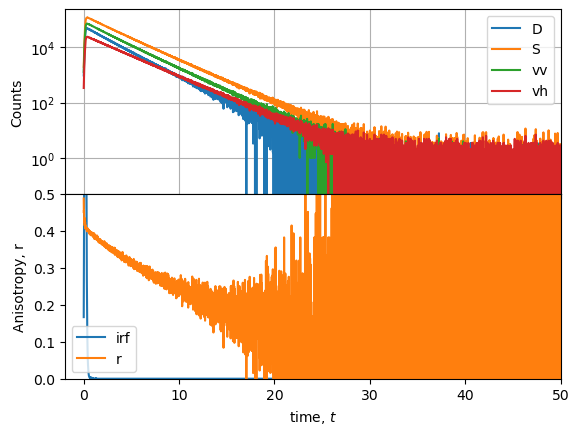

In [113]:
fig = plt.figure()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].semilogy(D.x, D.y, label="D")
axs[0].semilogy(S.x, S.y, label="S")
axs[0].semilogy(vv.x, vv.y, label="vv")
axs[0].semilogy(vh_c.x, vh_c.y, label="vh")
axs[0].legend()
axs[0].set_ylabel('Counts')
axs[0].grid(True)

irf_y = irf.y
irf_y /= max(irf_y) * 0.4 # scale IRF for plot
axs[1].plot(irf.x, irf_y, label="irf")
axs[1].plot(r.x, r.y, label="r")
axs[1].legend()
axs[1].set_ylabel('Anisotropy, r')
axs[1].set_xlabel('Time [ns]')
axs[1].set_ylim(0, 0.5)
axs[1].set_xlim(-2, 50)


The rotational correlation time can be estimated by the maximum of the curve $r(t) \cdot t$.

In [121]:
from scipy import signal

rt_s = signal.savgol_filter(
    r.y * t,
    103, # window size used for filtering
    3   # order of fitted polynomial
)

(0.0, 50.0)

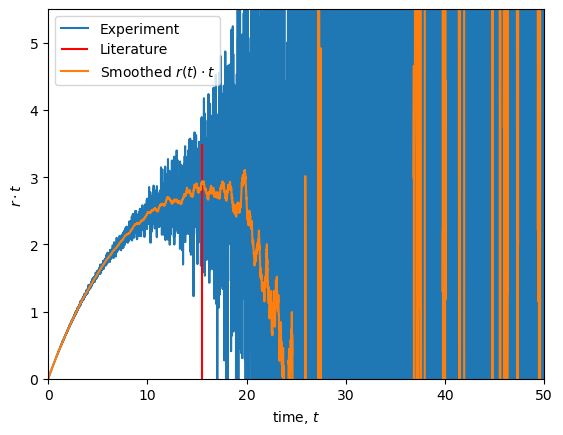

In [125]:
fig = plt.figure()
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

r_rot_lit = 15.5
axs.plot(r.x, r.y * t, label="Experiment")
axs.vlines(r_rot_lit, 0, 3.5, label="Literature", color="red")
axs.plot(r.x, rt_s, label="Smoothed $r(t)\cdot t$")
axs.legend()
axs.set_xlabel('Time [ns]')
axs.set_ylabel('$r \cdot t$')
axs.set_ylim(0, 5.5)
axs.set_xlim(0, 50)

The maximum of $r(t) \cdot t$ is close to the literature value of 15.5 ns <cite data-cite="striker1999photochromicity">Striker et al. (1999)</cite>.